# Utils

## Set up

In [68]:
import os
from scipy.io import loadmat
import shutil
import h5py
import sys
import numpy as np
import matplotlib.pyplot as plt
from Images.utils_neuromaps_brain import *
from nilearn import datasets, surface, plotting
import nibabel as nib
from nilearn.image import new_img_like
from matplotlib import ticker
from matplotlib import colors
import matplotlib.colors as mcolors
import re

In [56]:
tree_path = "/home/sun/Projects/RHOSTS/Sample_results"
sub1_input = "/home/sun/Projects/RHOSTS/input/subject1_left.txt"
sub1_output = "/home/sun/Projects/RHOSTS/output/subject1_left_results.txt"
sub1_output_sorted = "/home/sun/Projects/RHOSTS/output/subject1_left_results.sorted.txt"
sub1_output_proj = '/home/sun/Projects/RHOSTS/output/sub1_left_weighted.hd5'
sub1_scaffold = '/home/sun/Projects/RHOSTS/output/scaffold_gen/'
path_scaffold_folder = '/home/sun/Projects/RHOSTS/High_order_TS_with_scaffold'
generators0 = "/home/sun/Projects/RHOSTS/output/scaffold_gen/generators__0.pck"


In [38]:
from matplotlib import font_manager as fm, rcParams
import glob, os

# registra esplicitamente i TTF installati localmente
for path in glob.glob(os.path.expanduser("~/.local/share/fonts/PTSerif/*.ttf")):
    fm.fontManager.addfont(path)

# imposta la famiglia
rcParams["font.family"] = "PT Serif"

# verifica
print(sorted({f.name for f in fm.fontManager.ttflist if "PT Serif" in f.name}))

for path in glob.glob(os.path.expanduser("~/.local/share/fonts/PTSerifCaption/*.ttf")):
    fm.fontManager.addfont(path)

rcParams["font.family"] = "PT Serif Caption"  # se vuoi usare la Caption
print(sorted({f.name for f in fm.fontManager.ttflist if "PT Serif" in f.name}))

['PT Serif']


## Project Exploration

Some info about the files

In [3]:
def print_tree(start_path, prefix=''):
    for i, item in enumerate(sorted(os.listdir(start_path))):
        path = os.path.join(start_path, item)
        connector = "└── " if i == len(os.listdir(start_path)) - 1 else "├── "
        print(prefix + connector + item)
        if os.path.isdir(path):
            extension = "    " if i == len(os.listdir(start_path)) - 1 else "│   "
            print_tree(path, prefix + extension)

In [4]:
print_tree(tree_path)

├── edges_projection_T0_1200_N50.hd5
├── results_T0_1200_N50.txt
├── results_sub1_left_1200.txt.hd5
└── trial_gen
    ├── generators__0.pck
    ├── generators__1.pck
    ├── generators__2.pck
    ├── generators__3.pck
    └── generators__4.pck


# Brain

## Input Data

One subject example taken from [HCP]

- 119 rows: Representing 119 brain regions of interest (ROIs).

- 1200 columns: Representing time points or temporal samples.


In [5]:

np.loadtxt(sub1_input).shape

(1200, 119)

## Output Data

Dati di output del soggetto sopra

### Check and order

In [55]:
rows = []
bad  = []

with open(sub1_output, "r") as f:
    for ln, line in enumerate(f, start=1):
        s = line.strip()
        if not s:
            continue
        parts = s.split()
        try:
            t = int(parts[0])                # time point
            vals = list(map(float, parts[1:]))  # il resto come float
            rows.append((t, vals, s))
        except Exception:
            bad.append((ln, s))

print("Numero righe totali :", len(rows) + len(bad))
print("Righe valide (con time point intero):", len(rows))
print("Righe scartate:", len(bad))
if bad:
    print("Prime 5 righe scartate:")
    for ln, s in bad[:5]:
        print(f"  linea {ln}: {s}")

rows_sorted = sorted(rows, key=lambda r: r[0])


from collections import Counter
cnt = Counter(ts)
duplicati = sorted([t for t, c in cnt.items() if c > 1])
mancanti = sorted(set(range(min(ts), max(ts)+1)) - set(ts))

print("Time points duplicati (se presenti):", duplicati if duplicati else "Nessuno")
print("Time points mancanti:", mancanti if mancanti else "Nessuno")

out = sub1_output.rsplit(".", 1)[0] + ".sorted.txt"
with open(out, "w") as w:
    for _, _, line in rows_sorted:
        w.write(line + "\n")
print("File ordinato scritto in:", out)


Numero righe totali : 1200
Righe valide (con time point intero): 1200
Righe scartate: 0
Time points duplicati (se presenti): Nessuno
Time points mancanti: Nessuno
File ordinato scritto in: /home/sun/Projects/RHOSTS/output/subject1_left_results.sorted.txt


In [96]:
# regex per estrarre il numero dal nome file
pat = re.compile(r"generators__([0-9]+)\.pck")

timepoints = []
for f in os.listdir(sub1_scaffold):
    m = pat.match(f)
    if m:
        timepoints.append(int(m.group(1)))

timepoints = sorted(timepoints)
print(f"Trovati {len(timepoints)} file")

if timepoints:
    print(f"Min timepoint: {timepoints[0]}  Max timepoint: {timepoints[-1]}")

    # intervallo atteso = tutti i time points da min a max
    expected = set(range(timepoints[0], timepoints[-1] + 1))
    missing = sorted(expected - set(timepoints))

    print(f"Mancano {len(missing)} timepoints")


Trovati 1085 file
Min timepoint: 0  Max timepoint: 1199
Mancano 115 timepoints


In [97]:
sorted(missing)

[2,
 3,
 4,
 5,
 10,
 11,
 12,
 13,
 14,
 72,
 97,
 98,
 116,
 242,
 382,
 383,
 384,
 385,
 389,
 398,
 399,
 400,
 401,
 402,
 422,
 453,
 454,
 455,
 461,
 462,
 463,
 464,
 465,
 473,
 474,
 475,
 476,
 477,
 588,
 589,
 590,
 636,
 637,
 718,
 719,
 720,
 721,
 743,
 744,
 745,
 746,
 760,
 761,
 762,
 763,
 824,
 828,
 829,
 830,
 831,
 832,
 846,
 878,
 879,
 880,
 881,
 929,
 942,
 943,
 944,
 945,
 946,
 953,
 954,
 955,
 956,
 957,
 958,
 959,
 980,
 1020,
 1021,
 1022,
 1023,
 1024,
 1030,
 1031,
 1032,
 1120,
 1121,
 1122,
 1131,
 1132,
 1138,
 1139,
 1140,
 1141,
 1142,
 1149,
 1150,
 1151,
 1152,
 1154,
 1155,
 1156,
 1157,
 1158,
 1159,
 1167,
 1168,
 1189,
 1191,
 1192,
 1193,
 1194]

### Hyper-Complexity indicators

Sort the output data by time and plot the Hyper-Complexity

In [13]:
output_data_sort = sub1_output_sorted[np.argsort(sub1_output_sorted[:, 0])]

Text(0, 0.5, 'Hyper-Complexity')

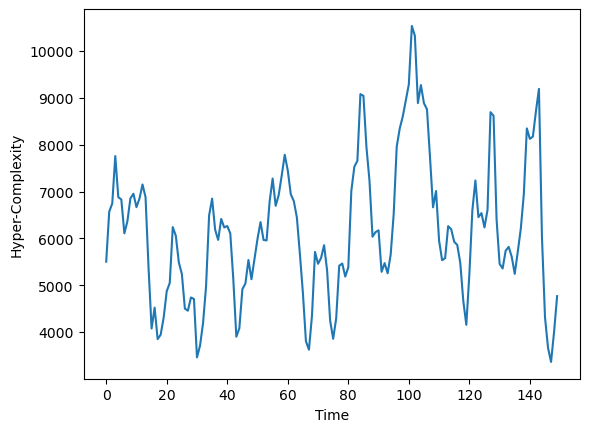

In [14]:
plt.plot(output_data_sort[:,0],output_data_sort[:,1])
plt.xlabel("Time")
plt.ylabel("Hyper-Complexity")

### Edges projection file

Ogni dataset corrisponde ad un time point

In [16]:
def print_first_n_datasets(h5_path, n=10):
    with h5py.File(h5_path, "r") as f:
        count = 0
        print(f"Maximum {n} dataset:\n")
        for name in f:
            obj = f[name]
            if isinstance(obj, h5py.Dataset):
                print(f"[DATASET] {name} → shape: {obj.shape}, dtype: {obj.dtype}")
                count += 1
                if count >= n:
                    break
        print(f"\nTotal dataset: {len(f.keys())}")

# Esegui
print_first_n_datasets(sub1_output_proj, n=10)

Maximum 10 dataset:

[DATASET] 0 → shape: (3487, 4), dtype: float32
[DATASET] 1 → shape: (3493, 4), dtype: float32
[DATASET] 10 → shape: (3613, 4), dtype: float32
[DATASET] 100 → shape: (3481, 4), dtype: float32
[DATASET] 101 → shape: (3501, 4), dtype: float32
[DATASET] 102 → shape: (3491, 4), dtype: float32
[DATASET] 103 → shape: (3483, 4), dtype: float32
[DATASET] 104 → shape: (3482, 4), dtype: float32
[DATASET] 105 → shape: (3492, 4), dtype: float32
[DATASET] 106 → shape: (3511, 4), dtype: float32

Total dataset: 150


In [17]:
with h5py.File(sub1_output_proj, "r") as f:
    dataset = f["77"][:]  # puoi cambiare il numero
    print("Shape:", dataset.shape)
    print("First rows:")
    for row in dataset[:5]:
        i, j, k, weight = row
        print(f"Triangle: ({int(i)}, {int(j)}, {int(k)}), peso: {weight:.4f}")


Shape: (3691, 4)
First rows:
Triangle: (19, 20, 128), peso: 62.0000
Triangle: (19, 98, 130), peso: 69.0000
Triangle: (20, 98, 167), peso: 71.0000
Triangle: (16, 20, 122), peso: 68.0000
Triangle: (16, 98, 132), peso: 67.0000


This below is a list of weighted edges at time t=0

Columns of the array:
- node $i$
- node $j$
- Magnitude edge $w_{ij}$ → la somma dei pesi dei triangoli violanti che includono quell’arco
- Times edge $(i,j)$ belongs to triangle $(i,j,\bullet)$ ] → quanti triangoli violanti contengono quell’arco


In [18]:
edge_files_sub1=h5py.File(sub1_output_proj)

In [19]:
edge_files_sub1['0'][:]

array([[9.30000000e+01, 1.08000000e+02, 1.26615135e+02, 5.30000000e+01],
       [9.30000000e+01, 1.17000000e+02, 6.19679451e+01, 5.00000000e+01],
       [1.08000000e+02, 1.17000000e+02, 1.31365463e+02, 5.50000000e+01],
       ...,
       [3.40000000e+01, 1.16000000e+02, 1.04387067e-01, 2.00000000e+00],
       [7.60000000e+01, 1.12000000e+02, 5.59808835e-02, 1.00000000e+00],
       [7.20000000e+01, 1.12000000e+02, 1.99358106e-01, 5.00000000e+00]],
      dtype=float32)

In [20]:
edge_files_sub1.close()

### Homological Scaffold file

In [17]:
sys.path.append(path_scaffold_folder)  # add parent directory to import the module Holes
import Holes as ho
import pickle as pk
import networkx as nx

Defines a function to load the scaffold graph

In [18]:
def load_scaffold_singletime(filepath_scaffold, single_time, ScafH=nx.Graph(), hom_group=1):
    f = open(filepath_scaffold + 'generators__{0}.pck'.format(single_time), 'rb')

    gen = pk.load(f)

    edges = []
    for c in gen[hom_group]:
        for e in c.cycles():
            #print(e)
            u, v = int(e[0]), int(e[1])
            if ScafH.has_edge(u, v):
                ScafH[u][v]['weight'] += c.persistence_interval()
            else:
                ScafH.add_edge(u, v, weight=c.persistence_interval())
    f.close()
    return (ScafH)



In [19]:
ScafH = load_scaffold_singletime(
    sub1_scaffold ,
    single_time='0',
    ScafH=nx.Graph(),
    hom_group=1
)

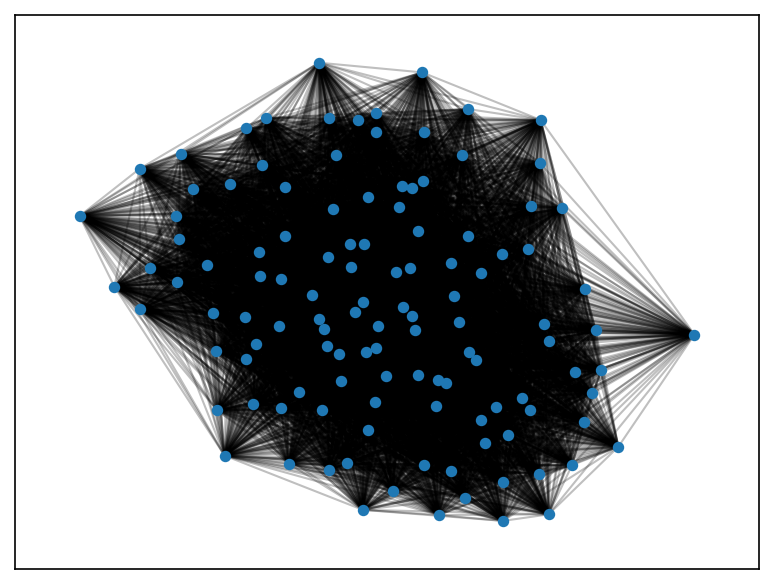

In [20]:
plt.figure(dpi=150)
layout = nx.drawing.layout.spring_layout(ScafH)
nx.draw_networkx_edges(ScafH, pos=layout,alpha=0.25)
nx.draw_networkx_nodes(ScafH, pos=layout,node_size=20)

In [23]:
import pickle as pk


# Carica il dizionario
with open(generators0, "rb") as f:
    generator_dict = pk.load(f)

# stampa le dimensioni omologiche presenti (es: 1, 2, ...)
print("Omology groups presenti:", list(generator_dict.keys()))

# esplora H1 (cicli di 1° ordine)
cycles_H1 = generator_dict[1]  # oppure cambia il numero per H2, ecc
print(f"\nNumero di cicli H1:", len(cycles_H1))

# stampa i primi 3 cicli
for i, cycle in enumerate(cycles_H1[:3]):
    print(f"\nCiclo {i+1}")
    print("  Persistenza:", cycle.persistence_interval())
    print("  Archi:", cycle.cycles())
    print("  Nodi:", cycle.cycle_nodes())


Omology groups presenti: [1]

Numero di cicli H1: 6903

Ciclo 1
  Persistenza: 0.12934851338171294
  Archi: [['49', '51'], ['51', '117'], ['49', '117']]
  Nodi: ['49', '51', '117']

Ciclo 2
  Persistenza: 0.13362065606944418
  Archi: [['76', '78'], ['78', '117'], ['76', '117']]
  Nodi: ['117', '76', '78']

Ciclo 3
  Persistenza: 0.22459316499541404
  Archi: [['49', '75'], ['62', '75'], ['49', '62']]
  Nodi: ['49', '75', '62']


## Plotting the nodal strength

### Violating triangles

In [72]:
num_ROIs = 119
cmap = mcolors.LinearSegmentedColormap.from_list(
    "green_yellow_red",
    ["#2ca25f", "#ffffbf", "#d73027"])

In [64]:
def compute_nodal_strength(triangle_data, num_ROIs=100):
    edge_weights = {}  # key: (i,j), value: [sum_w, count]

    for row in triangle_data:
        i, j = int(row[0]), int(row[1])
        sum_w = row[2]
        count = row[3]
        edge = tuple(sorted((i, j)))
        if count > 0:
            w_ij = sum_w / count
            if edge not in edge_weights:
                edge_weights[edge] = w_ij

    nodal_strength = np.zeros(num_ROIs)

    for (i, j), w_ij in edge_weights.items():
        if i < num_ROIs:
            nodal_strength[i] += w_ij
        if j < num_ROIs:
            nodal_strength[j] += w_ij

    return nodal_strength

Qui plotto un solo fame, quindi un solo istante
 temporale

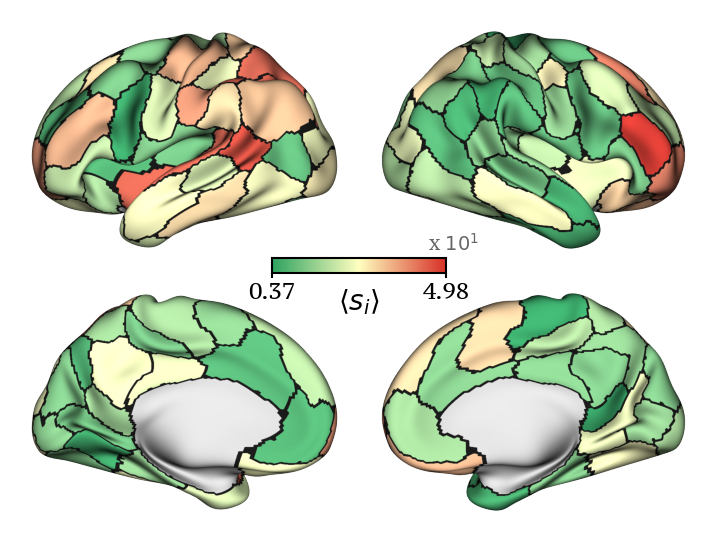

In [73]:
with h5py.File(sub1_output_proj, "r") as f:
    triangle_data = f["0"][:]  # Frame 0
    nodal_strength_single = compute_nodal_strength(triangle_data, num_ROIs=100)

fig = normal_view(
    current_nodestrength=nodal_strength_single,
    edges=True,
    cmap = cmap,
    q_thresh=0.0,
    center_cbar=True,
    alpha_graymap=0.99,
    xlabel=r"$\langle s_i \rangle$"
)

Qui plotto tutti gli istanti temporali del mio file, concatenandoli

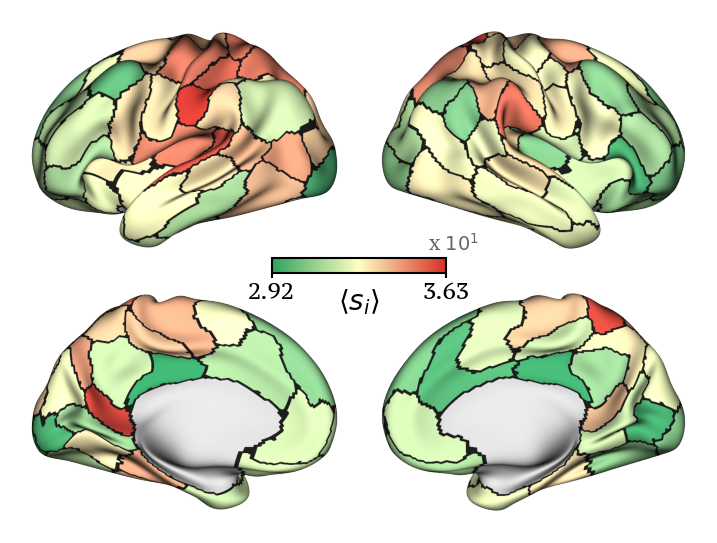

In [74]:
all_nodal_strengths = []

with h5py.File(sub1_output_proj, "r") as f:
    for key in f.keys():
        triangle_data = f[key][:]
        nodal_strength = compute_nodal_strength(triangle_data, num_ROIs=100)
        all_nodal_strengths.append(nodal_strength)

mean_nodal_strength = np.mean(np.stack(all_nodal_strengths), axis=0)

fig = normal_view(
    current_nodestrength=mean_nodal_strength,
    edges=True,
    cmap=cmap,    #RdBu_r
    q_thresh=0.0,
    center_cbar=True,
    alpha_graymap=0.99,
    xlabel=r"$\langle s_i \rangle$"
)


Plotta i 15 frames temporali più coerenti

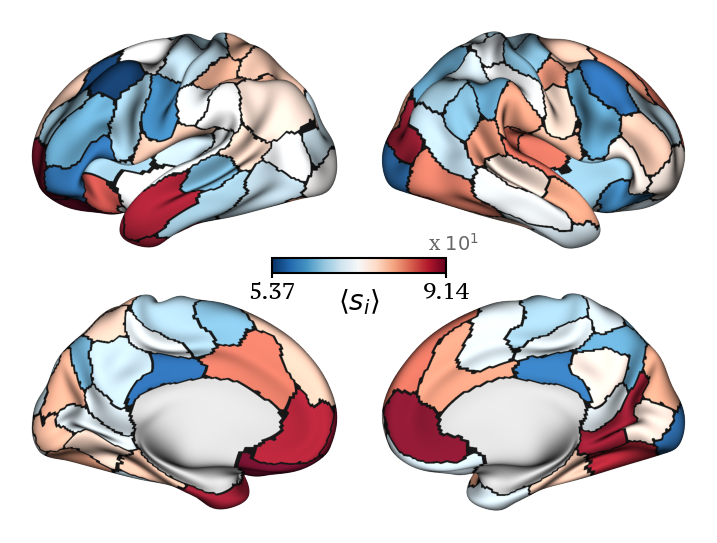

In [67]:
# Load results and select top 15% timepoints by hyper-coherence
results = np.loadtxt(sub1_output_sorted)
timepoints = results[:, 0].astype(int)
hyper_coherence = results[:, 5]

n_top = int(np.ceil(len(timepoints) * 0.15))
top_indices = np.argsort(hyper_coherence)[-n_top:]
top_timepoints = timepoints[top_indices]

top_nodal_strengths = []

with h5py.File(sub1_output_proj, "r") as f:
    for t in top_timepoints:
        triangle_data = f[str(t)][:]
        nodal_strength = compute_nodal_strength(triangle_data, num_ROIs=100)
        top_nodal_strengths.append(nodal_strength)

mean_top_nodal_strength = np.mean(np.stack(top_nodal_strengths), axis=0)

fig = normal_view(
    current_nodestrength=mean_top_nodal_strength,
    edges=True,
    cmap=cmap,
    q_thresh=0.0,
    center_cbar=True,
    alpha_graymap=0.99,
    xlabel=r"$\langle s_i \rangle$"
)


### Homological scaffold

Plot per singolo frame

In [36]:
def compute_nodal_strength_from_scaffold(path_pck, num_ROIs=100):
    with open(path_pck, "rb") as f:
        generator_dict = pk.load(f)

    ScafH = nx.Graph()
    for c in generator_dict[1]:  # H1
        for e in c.cycles():
            u, v = int(e[0]), int(e[1])
            w = c.persistence_interval()
            if ScafH.has_edge(u, v):
                ScafH[u][v]['weight'] += w
            else:
                ScafH.add_edge(u, v, weight=w)

    nodal_strength = np.zeros(num_ROIs)
    for node in ScafH.nodes:
        if node < num_ROIs:
            nodal_strength[node] = sum(d['weight'] for _, _, d in ScafH.edges(node, data=True))
    return nodal_strength

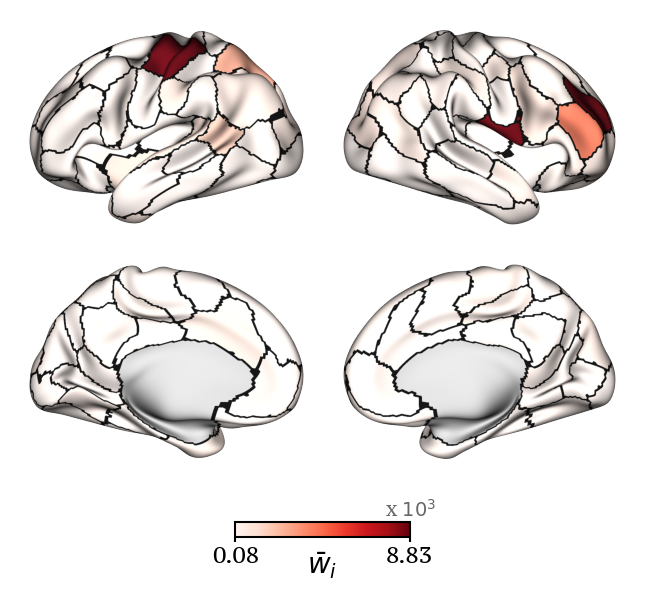

In [80]:
single_frame_path = os.path.join(sub1_scaffold, "generators__0.pck")
nodal_strength_0 = compute_nodal_strength_from_scaffold(single_frame_path, num_ROIs=num_ROIs)

fig = normal_view(
    current_nodestrength=nodal_strength_0,
    edges=True,
    cmap='Reds',
    q_thresh=0.0,
    center_cbar=False,
    alpha_graymap=0.99,
    xlabel=r"$\bar{w}_i$"
)

Tutti i frame

In [ ]:
# Directory contenente i file .pck
pck_paths = sorted(glob.glob(os.path.join(sub1_scaffold, "generators__*.pck")))
print(f"Found {len(pck_paths)} frames.")

# Lista per salvare la nodal strength di ciascun frame
all_strengths = []

for path in pck_paths:
    nodal_strength = compute_nodal_strength_from_scaffold(
        path,
        num_ROIs=num_ROIs
    )
    all_strengths.append(nodal_strength)

# Calcolo della media su tutti i frame
mean_all = np.mean(np.stack(all_strengths), axis=0)

# Visualizzazione
fig = normal_view(
    current_nodestrength=mean_all,
    edges=True,
    cmap="Reds",
    q_thresh=0.0,
    center_cbar=False,
    alpha_graymap=0.99,
    xlabel=r"$\langle \bar{w}_i \rangle$"
)


15 frame a minore hyper-complexity

In [57]:
results = np.loadtxt(sub1_output_sorted)
timepoints = results[:, 0].astype(int)
complexity = results[:, 1]

n_top = int(np.ceil(len(timepoints) * 0.15))
top_timepoints = timepoints[np.argsort(complexity)[:n_top]]
print(top_timepoints)


[ 419  420 1052  147  183 1199  418   30  182  151   67  376  146  485
   31  414  343   66 1053   17   75  543  544   43  181 1101   18  486
  374  973  148  773  724  977  782  329  972  172  571   15   44  974
  341 1035  344  785  786  184  578  119  342  375  237   32  976  340
 1054  359  572   74  421 1051  373  150  966   76 1102   19  145 1065
  328  570  295   68  772  774  545  288  793  927  197  403  287  404
  417  714  360   27  297  415  502  361  725   26 1036   16  277  196
  542  330  289  971  236  413  233  967  577  926  775  568  713  298
  296  924  915  781  551  118  162 1064  232  784  235  783   29  787
  198  163  541  185  171  173  294  276  663   28  639 1126  670  484
  149  533  380  579  377  457  715  975 1088  664  723 1062  919  234
  633   65  345  918  978   20  771 1085  553 1055  794  562  362  273
  638  817  177  668  965  203  372  479  550   45  549  854]


In [90]:
count = 0
for n in top_timepoints:
    if n not in missing:
        count +=1
    else:
        print(f"{n} is missing")
print (f"\nFound {count} frames.")
print(f"Total top timepoints: {len(top_timepoints)}")

1030 is missing
1152 is missing
1156 is missing
1154 is missing
465 is missing
242 is missing
1032 is missing
1120 is missing
72 is missing
98 is missing
422 is missing
746 is missing
1189 is missing
1155 is missing
1157 is missing
1031 is missing
929 is missing
881 is missing
1138 is missing
1142 is missing
1020 is missing
828 is missing
5 is missing
385 is missing
959 is missing
1191 is missing
1193 is missing
763 is missing
637 is missing
382 is missing
464 is missing
1122 is missing
588 is missing
1131 is missing
1159 is missing
953 is missing
718 is missing
10 is missing
719 is missing
97 is missing
980 is missing
1192 is missing
1194 is missing
636 is missing
590 is missing
720 is missing
1141 is missing
455 is missing
1168 is missing
745 is missing
453 is missing
1139 is missing
384 is missing
1132 is missing
832 is missing
473 is missing
958 is missing
1140 is missing
1158 is missing
383 is missing
1024 is missing
116 is missing
762 is missing
461 is missing
721 is missing
878 

File mancante per time point 1030, salto...
File mancante per time point 1152, salto...
File mancante per time point 1156, salto...
File mancante per time point 1154, salto...
File mancante per time point 465, salto...
File mancante per time point 242, salto...
File mancante per time point 1032, salto...
File mancante per time point 1120, salto...
File mancante per time point 72, salto...
File mancante per time point 98, salto...
File mancante per time point 422, salto...
File mancante per time point 746, salto...
File mancante per time point 1189, salto...
File mancante per time point 1155, salto...
File mancante per time point 1157, salto...
File mancante per time point 1031, salto...
File mancante per time point 929, salto...
File mancante per time point 881, salto...
File mancante per time point 1138, salto...
File mancante per time point 1142, salto...
File mancante per time point 1020, salto...
File mancante per time point 828, salto...
File mancante per time point 5, salto...
Fi

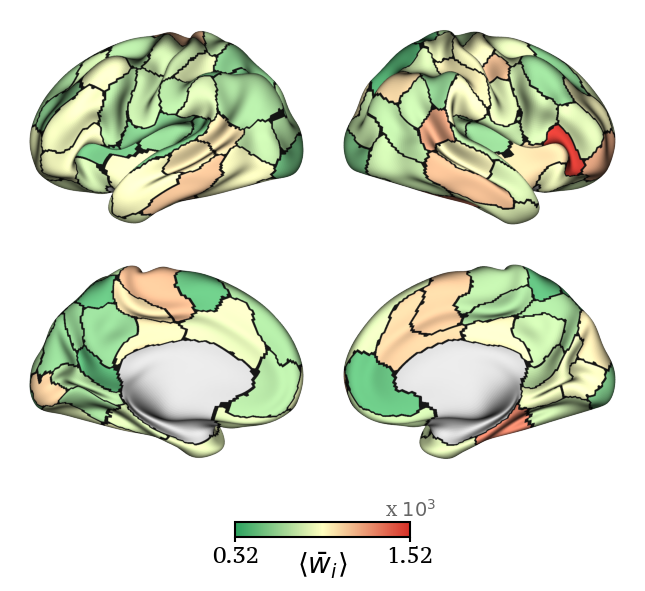

In [91]:
strengths_top = []
for t in top_timepoints:
    path = os.path.join(sub1_scaffold, f"generators__{t}.pck")

    if not os.path.exists(path):
        print(f"File mancante per time point {t}, salto...")
        continue

    nodal_strength = compute_nodal_strength_from_scaffold(path, num_ROIs=num_ROIs)
    strengths_top.append(nodal_strength)

if strengths_top:  # solo se la lista non è vuota
    mean_top = np.mean(np.stack(strengths_top), axis=0)

    fig = normal_view(
        current_nodestrength=mean_top,
        edges=True,
        cmap=cmap,
        q_thresh=0.0,
        center_cbar=False,
        alpha_graymap=0.99,
        xlabel=r"$\langle \bar{w}_i \rangle$"
    )
else:
    print("Nessun time point valido trovato.")


In [ ]:
strengths_top = []
for t in top_timepoints:
    path = os.path.join(sub1_scaffold, f"generators__{t}.pck")
    nodal_strength = compute_nodal_strength_from_scaffold(path, num_ROIs=num_ROIs)
    strengths_top.append(nodal_strength)

mean_top = np.mean(np.stack(strengths_top), axis=0)

fig = normal_view(
    current_nodestrength=mean_top,
    edges=True,
    cmap=cmap,
    q_thresh=0.0,
    center_cbar=False,
    alpha_graymap=0.99,
    xlabel=r"$\langle \bar{w}_i \rangle$"
)

## Triangular representation

In [61]:
data = np.loadtxt(sub1_output_sorted)

# Extract FC, CT, FD contributions and sum up them
FC = data[:, 2]
CT = data[:, 3]
FD = data[:, 4]
total = FC + CT + FD

# Normalize
fc_norm = FC / total
ct_norm = CT / total
fd_norm = FD / total

# To map coordintes in a triangle
x = 0.5 * (2 * fd_norm + ct_norm)
y = (np.sqrt(3) / 2) * ct_norm

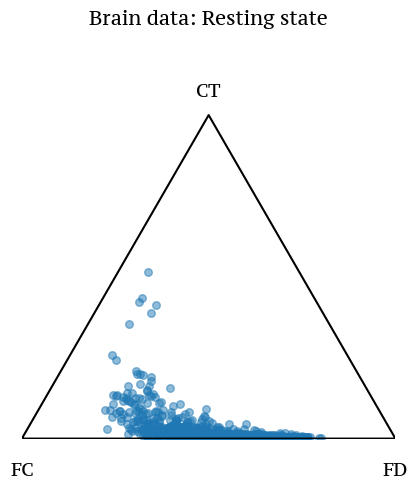

In [62]:
fig, ax = plt.subplots(figsize=(5.5, 5))

triangle = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2], [0, 0]])
ax.plot(triangle[:, 0], triangle[:, 1], color='black', lw=1.5)

ax.scatter(x, y, color="#1f78b4", alpha=0.5, s=30)

ax.text(0, -0.06, "FC", ha='center', va='top', fontsize=13)
ax.text(1, -0.06, "FD", ha='center', va='top', fontsize=13)
ax.text(0.5, np.sqrt(3)/2 + 0.04, "CT", ha='center', va='bottom', fontsize=13)
ax.set_title("Brain data: Resting state", fontsize=14, pad=25)
ax.set_xlim(0, 1)
ax.set_ylim(0, np.sqrt(3)/2 + 0.15)
ax.set_aspect('equal')
ax.axis('off')

plt.tight_layout()
plt.show()
